In [ ]:
!pip install transformers datasets onnx onnxruntime openvino-dev

In [ ]:
import numpy as np
import onnxruntime
import openvino
import torch
from datasets import load_dataset
from openvino.tools import mo
from transformers import AutoImageProcessor, AutoModelForImageClassification

In [ ]:
sample = load_dataset('cats_vs_dogs')['train'][7]

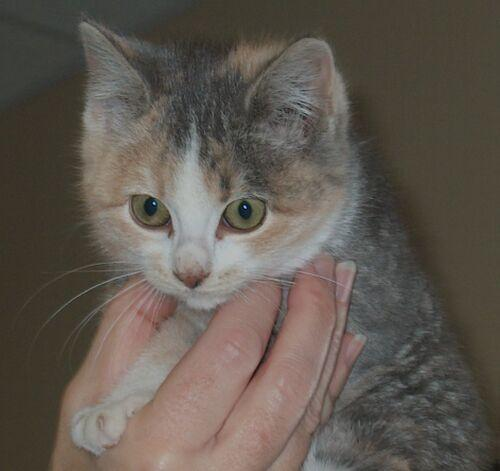

In [ ]:
sample['image']

In [ ]:
processor = AutoImageProcessor.from_pretrained('google/vit-base-patch16-224')
model = AutoModelForImageClassification.from_pretrained('google/vit-base-patch16-224')

model = model.eval()

In [ ]:
inputs = processor(sample['image'], return_tensors='pt')

In [ ]:
%%timeit

with torch.no_grad():
    logits = model(inputs['pixel_values'])['logits']

2.43 s ± 724 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
with torch.no_grad():
    logits = model(inputs['pixel_values'])['logits']

In [ ]:
prediction = logits.argmax(axis=-1)[0].item()
model.config.id2label[prediction]

'Egyptian cat'

## ONNX

In [ ]:
torch.onnx.export(
    model,
    {'pixel_values': inputs['pixel_values']},
    'vit-base-patch16-224.onnx',
    input_names=['pixel_values'],
    output_names=['logits'],
    dynamic_axes={
        'pixel_values': {0: 'batch'},
        'logits': {0: 'batch'},
    },
)

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/modeling_vit.py:170: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if num_channels != self.num_channels:
/usr/local/lib/python3.10/dist-packages/transformers/models/vit/modeling_vit.py:176: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if height != self.image_size[0] or width != self.image_size[1]:


In [ ]:
onnx_model = onnxruntime.InferenceSession('vit-base-patch16-224.onnx')
onnx_inputs = {'pixel_values': inputs['pixel_values'].numpy()}

In [ ]:
%%timeit

onnx_logits = onnx_model.run(['logits'], onnx_inputs)[0]

600 ms ± 10.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
onnx_logits = onnx_model.run(['logits'], onnx_inputs)[0]

In [ ]:
# check onnx outputs

np.testing.assert_allclose(
    logits.numpy(),
    onnx_logits,
    rtol=1e-02,
    atol=1e-05,
)

## Openvino

In [ ]:
openvino_model = mo.convert_model('vit-base-patch16-224.onnx', compress_to_fp16=False)
openvino.runtime.serialize(openvino_model, 'openvino_model/vit-base-patch16-224.xml')

In [ ]:
core = openvino.runtime.Core()
openvino_model = core.read_model('openvino_model/vit-base-patch16-224.xml')
openvino_compiled_model = core.compile_model(openvino_model, 'CPU')
openvino_inputs = {'pixel_values': inputs['pixel_values'].numpy()}

In [ ]:
%%timeit

openvino_logits = openvino_compiled_model(
    openvino_inputs,
)[openvino_compiled_model.output('logits')]

748 ms ± 160 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
openvino_logits = openvino_compiled_model(
    openvino_inputs,
)[openvino_compiled_model.output('logits')]

In [ ]:
# check openvino outputs

np.testing.assert_allclose(
    logits.detach().numpy(),
    openvino_logits,
    rtol=1e-03,
    atol=1e-05,
)